In [1]:
import torch 
import torch.nn as nn 

import h5py, os
import numpy as np
from matplotlib import pyplot as plt
from functions import transforms as T
from torch.nn import functional as F
from functions.subsample import MaskFunc
from scipy.io import loadmat
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
from math import exp
import torch.optim as optim
from skimage.measure import compare_ssim

In [2]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'  # check whether a GPU is available
torch.cuda.empty_cache()

In [3]:
def show_slices(data, slice_nums, cmap=None): # visualisation
    fig = plt.figure(figsize=(15,10))
    for i, num in enumerate(slice_nums):
        plt.subplot(1, len(slice_nums), i + 1)
        plt.imshow(data[num], cmap=cmap)
        plt.axis('off')

In [4]:
class MRIDataset(DataLoader):
    def __init__(self, data_list, acceleration, center_fraction):
        self.data_list = data_list
        self.acceleration = acceleration
        self.center_fraction = center_fraction

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        subject_id = self.data_list[idx]
        return get_epoch_batch(subject_id, self.acceleration, self.center_fraction)

In [5]:
def get_epoch_batch(subject_id, acc, center_fract, use_seed=False):
    ''' random select a few slices (batch_size) from each volume'''

    fname, rawdata_name, slice = subject_id  
    
    with h5py.File(rawdata_name, 'r') as data:
        rawdata = data['kspace'][slice]
                      
    slice_kspace = T.to_tensor(rawdata).unsqueeze(0)
    S, Ny, Nx, ps = slice_kspace.shape

    # apply random mask
    shape = np.array(slice_kspace.shape)
    mask_func = MaskFunc(center_fractions=center_fract, accelerations=acc)
    seed = None if not use_seed else tuple(map(ord, fname))
    mask = mask_func(shape, seed)
      
    # undersample
    masked_kspace = torch.where(mask == 0, torch.Tensor([0]), slice_kspace)

    img_gt, img_und = T.ifft2(slice_kspace), T.ifft2(masked_kspace)

    # perform data normalization which is important for network to learn useful features
    # during inference there is no ground truth image so use the zero-filled recon to normalize
    norm = T.complex_abs(img_und).max()
    if norm < 1e-6: norm = 1e-6
    
    # normalized data
    img_gt, img_und = img_gt/norm, img_und/norm
        
    img_gt, img_und = img_gt.squeeze(0), img_und.squeeze(0)
    
    img_gt, img_und = T.complex_abs(img_gt), T.complex_abs(img_und)
    
    return T.center_crop(img_gt, (320, 320)), T.center_crop(img_und, (320, 320))

In [6]:
def load_data_path(data_path):
    """ Go through each subset (training, validation) and list all 
    the file names, the file paths and the slices of subjects in the training and validation sets 
    """

    data_list = {}
    train_and_val = ['train', 'val']
    limit = 60
    
        
    files = sorted(os.listdir(data_path))
    
    for i in range(len(train_and_val)):

        data_list[train_and_val[i]] = []
        
        if i == 0 : selected_files = files[:limit]
        else : selected_files = files[limit:]
    
        for fname in selected_files:
                
            subject_data_path = os.path.join(data_path, fname)
                     
            if not os.path.isfile(subject_data_path): continue
            
            with h5py.File(subject_data_path, 'r') as data:
                num_slice = data['kspace'].shape[0]
                
            # the first 5 slices are mostly noise so it is better to exlude them
            if i == 1:
                data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(0, num_slice)]
            else:
                data_list[train_and_val[i]] += [(fname, subject_data_path, slice) for slice in range(14, 25)]
    
    return data_list  

In [7]:
#PREPARE THE DATA 
data_list = load_data_path('/data/local/NC2019MRI/train')

acc = [4,8]
cen_fract = [0.08, 0.04]
num_workers = 10 # data loading is faster using a bigger number for num_workers. 0 means using one cpu to load data
    
# create data loader for training set. It applies same to validation set as well
train_dataset = MRIDataset(data_list['train'], acceleration=acc, center_fraction=cen_fract)
train_loader = DataLoader(train_dataset, shuffle=True, batch_size=5, num_workers=num_workers)

In [8]:
class ConvolutionalBlock(nn.Module):

    def __init__(self, in_chans, out_chans):
        super().__init__()

        self.in_chans = in_chans
        self.out_chans = out_chans

        self.layers = nn.Sequential(
            
            nn.Conv2d(in_chans, out_chans, kernel_size=3, padding=1, padding_mode='zeros', bias=False),
            nn.BatchNorm2d(out_chans),
            nn.ReLU(inplace=True),
        )
        

    def forward(self, input):
        
        return self.layers(input)



In [9]:
class UNet(nn.Module):

    def __init__(self, input_chans, output_chans, chans, depth=3, level_len=1):

        super().__init__()
        

        self.chans = chans
        self.depth = depth
        self.level_len = level_len
        self.encoding_layers = nn.ModuleList()
        
        out_chans = chans
        
        # First level
        self.encoding_layers.append(ConvolutionalBlock(input_chans, chans))
        
        for j in range(level_len):
            self.encoding_layers.append(ConvolutionalBlock(chans, chans))
            
        self.encoding_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
        
        '''ENCODER'''
        for i in range(depth-2):
            in_chans = out_chans
            out_chans = int(out_chans * 2)
            self.encoding_layers.append(ConvolutionalBlock(in_chans, out_chans))
            
            for j in range(level_len):
                self.encoding_layers.append(ConvolutionalBlock(out_chans, out_chans))
                
            self.encoding_layers.append(nn.MaxPool2d(kernel_size=2, stride=2))
            
                               
        in_chans = out_chans
        out_chans = int(out_chans * 2)
        self.encoding_layers.append(ConvolutionalBlock(in_chans, out_chans))
        
        for j in range(level_len):
            self.encoding_layers.append(ConvolutionalBlock(out_chans, out_chans))       
        
        
        
        '''DECODER'''
        self.decoding_layers = nn.ModuleList()
                    
                                    
        in_chans = out_chans
        out_chans = int(in_chans / 2)
                                    
        self.decoding_layers.append(nn.ConvTranspose2d(in_chans, out_chans, kernel_size=2, stride=2)) 
                                    
        for i in range(depth-2):
            
            self.decoding_layers.append(ConvolutionalBlock(in_chans, out_chans))
            
            for j in range(level_len):
                self.decoding_layers.append(ConvolutionalBlock(out_chans, out_chans))
                
            in_chans = out_chans
            out_chans = int(out_chans / 2)
            self.decoding_layers.append(nn.ConvTranspose2d(in_chans, out_chans, kernel_size=2, stride=2))
                                    
        self.decoding_layers.append(ConvolutionalBlock(in_chans, out_chans))
        
        for j in range(level_len): 
            self.decoding_layers.append(ConvolutionalBlock(out_chans, out_chans))
        
        '''FINAL CONV'''
        
        self.finalConv = nn.Conv2d(in_channels=out_chans, out_channels=output_chans, kernel_size=1)
     
        
    def forward(self, input):

        level_output = []
        index_to_save = 1
                                    
        '''ENCODE'''  
        
        for i, layer in enumerate(self.encoding_layers):
            input = layer(input)
            if i == index_to_save: 
                level_output.append(input)
                index_to_save += 2 + self.level_len             
                                    
                                    

        '''DECODE'''
        index_to_cat = 0
        for i, layer in enumerate(self.decoding_layers):
            input = layer(input)
            if i == index_to_cat:
                level_output.pop()
                index_to_cat += 2 + self.level_len  
                input =  torch.cat((input, level_output[-1]), dim=1)

        
        output = self.finalConv(input)

        return output 

In [10]:
#create a model
model = UNet(
    input_chans=1,
    output_chans=1,
    chans=32,
    depth=3,
    level_len=4
).to(device)

In [11]:
#ssim loss
def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size//2)**2/float(2*sigma**2)) for x in range(window_size)])
    return gauss/gauss.sum()


def create_window(window_size, channel=1):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = _2D_window.expand(channel, 1, window_size, window_size).contiguous()
    return window


def ssim(img1, img2, window_size=11, window=None):
    # Value range can be different from 255. Other common ranges are 1 (sigmoid) and 2 (tanh).
    L = img1.max()

    padd = 0
    (_, channel, height, width) = img1.size()

    mu1 = F.conv2d(img1, window, padding=padd, groups=channel)
    mu2 = F.conv2d(img2, window, padding=padd, groups=channel)

    mu1_sq = mu1.pow(2)
    mu2_sq = mu2.pow(2)
    mu1_mu2 = mu1 * mu2

    sigma1_sq = F.conv2d(img1 * img1, window, padding=padd, groups=channel) - mu1_sq
    sigma2_sq = F.conv2d(img2 * img2, window, padding=padd, groups=channel) - mu2_sq
    sigma12 = F.conv2d(img1 * img2, window, padding=padd, groups=channel) - mu1_mu2

    C1 = (0.01 * L) ** 2
    C2 = (0.03 * L) ** 2

    v1 = 2.0 * sigma12 + C2
    v2 = sigma1_sq + sigma2_sq + C2
    cs = torch.mean(v1 / v2)  # contrast sensitivity

    ssim_map = ((2 * mu1_mu2 + C1) * v1) / ((mu1_sq + mu2_sq + C1) * v2)

    return ssim_map.mean()



# Classes to re-use window
class SSIM(torch.nn.Module):
    def __init__(self, window_size=11):
        super(SSIM, self).__init__()
        self.window_size = window_size

        # Assume 1 channel for SSIM
        self.channel = 1
        self.window = create_window(window_size)

    def forward(self, output_img, target_img):
        (_, channel, _, _) = output_img.size()
        
        if channel == self.channel and self.window.type == output_img.type:
            window = self.window
        else:
            window = create_window(self.window_size, channel).to(output_img.device).type(output_img.dtype)
            self.window = window
            self.channel = channel

        return 1 - ssim(target_img, output_img, window=window, window_size=self.window_size)

In [12]:
# set learning rate
lr = 1e-4
#optimiser
#stochastic gradient descent (SGD)
# optimiser = optim.SGD(model.parameters(), lr=lr)
optimiser = optim.Adam(model.parameters(), lr=lr)
# optimiser = torch.optim.RMSprop(model.parameters(), lr, weight_decay=wd)

In [13]:
ssim_loss = SSIM()

In [14]:
#train the network 

# set number of epoches, i.e., number of times we iterate through the training set
epochs = 100


for epoch in range(epochs):
    model.train() 
    mean = []
    for iter, data in enumerate(train_loader):
        target_img, input_img = data
        input_img = input_img.to(device).unsqueeze(1)
        target_img = target_img.to(device).unsqueeze(1)

        output_img = model(input_img)
        
        loss = ssim_loss(output_img, target_img)
        # loss = msssim_loss(output, target)
        # loss = F.l1_loss(output, target)
        mean.append(loss)
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        
    l = sum(mean)/len(mean)
    print("Epoch {}'s loss: {}".format(epoch, l))

Epoch 0's loss: 0.5023326873779297
Epoch 1's loss: 0.4260979890823364
Epoch 2's loss: 0.4130323529243469
Epoch 3's loss: 0.40415939688682556
Epoch 4's loss: 0.40655967593193054
Epoch 5's loss: 0.3971075117588043
Epoch 6's loss: 0.40248265862464905
Epoch 7's loss: 0.3972788453102112
Epoch 8's loss: 0.396537184715271
Epoch 9's loss: 0.38949671387672424
Epoch 10's loss: 0.3849095404148102
Epoch 11's loss: 0.39654451608657837
Epoch 12's loss: 0.38521045446395874
Epoch 13's loss: 0.38758549094200134
Epoch 14's loss: 0.3920333981513977
Epoch 15's loss: 0.3838602304458618
Epoch 16's loss: 0.3766881227493286
Epoch 17's loss: 0.38016173243522644
Epoch 18's loss: 0.3796685039997101
Epoch 19's loss: 0.3790688216686249
Epoch 20's loss: 0.37839195132255554
Epoch 21's loss: 0.37743625044822693
Epoch 22's loss: 0.3749009966850281
Epoch 23's loss: 0.3777049481868744
Epoch 24's loss: 0.3760882019996643
Epoch 25's loss: 0.3766767084598541
Epoch 26's loss: 0.37188902497291565
Epoch 27's loss: 0.372596502

In [25]:
PATH = 'model_final.h5'
torch.save(model.state_dict(), PATH)

In [26]:
torch.cuda.empty_cache()
model.load_state_dict(torch.load('model_final.h5'))
model.eval()

UNet(
  (encoding_layers): ModuleList(
    (0): ConvolutionalBlock(
      (layers): Sequential(
        (0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (1): ConvolutionalBlock(
      (layers): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (2): ConvolutionalBlock(
      (layers): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (2): ReLU(inplace=True)
      )
    )
    (3): ConvolutionalBlock(
      (layers): Sequential(
        (0): Conv2d(32, 32, kernel_size=(3, 

In [27]:
# create data loader for validation set
val_dataset = MRIDataset(data_list['val'], acceleration=acc, center_fraction=cen_fract)
val_loader = DataLoader(val_dataset, shuffle=False, batch_size=38, num_workers=num_workers)

In [28]:
def ssim_numpy(gt, pred):
    return compare_ssim(
        gt.transpose(1, 2, 0), pred.transpose(1, 2, 0), multichannel=True, data_range=gt.max()
    )

In [29]:
ssim_scores = []

with torch.no_grad():
    for iteration, sample in enumerate(val_loader):
    
        img_gt, img_und = sample
    
        output_img = model(img_und.to(device).unsqueeze(1)).cpu().numpy().squeeze()
        ssim_scores.append(ssim_numpy(img_gt.squeeze(1).numpy(), output_img))
            
numpy_ssims = np.array(ssim_scores)
print("Mean:", numpy_ssims.mean())

/bham/modules/roots/neural-comp/2019-20/lib/python3.6/site-packages/ipykernel_launcher.py:3: UserWarning: DEPRECATED: skimage.measure.compare_ssim has been moved to skimage.metrics.structural_similarity. It will be removed from skimage.measure in version 0.18.
  This is separate from the ipykernel package so we can avoid doing imports until


Mean: 0.7116522940130332


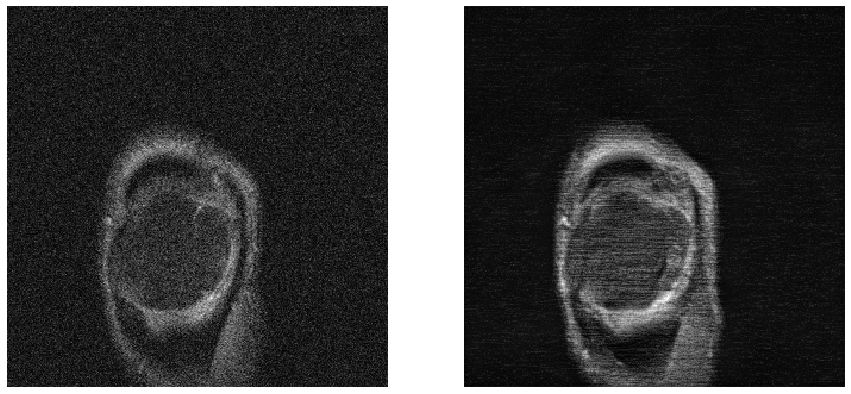

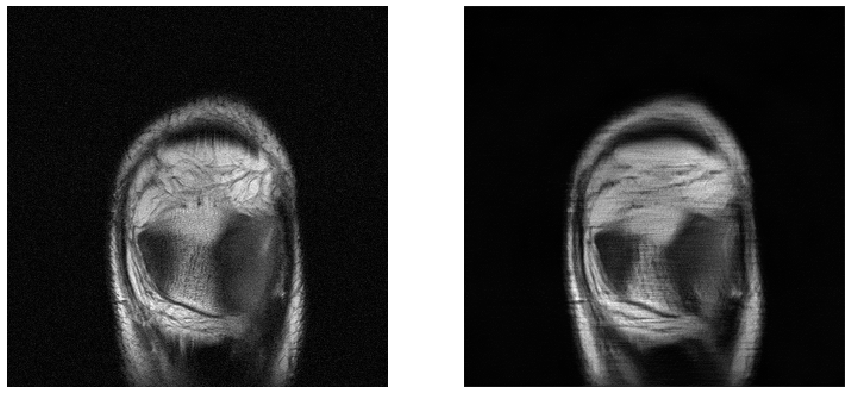

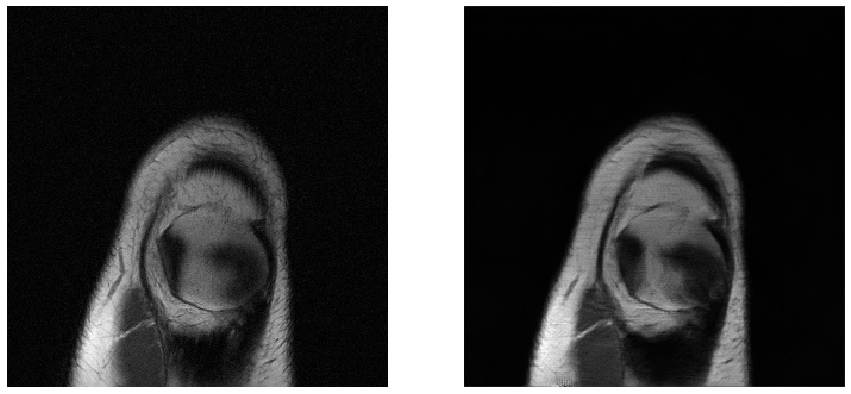

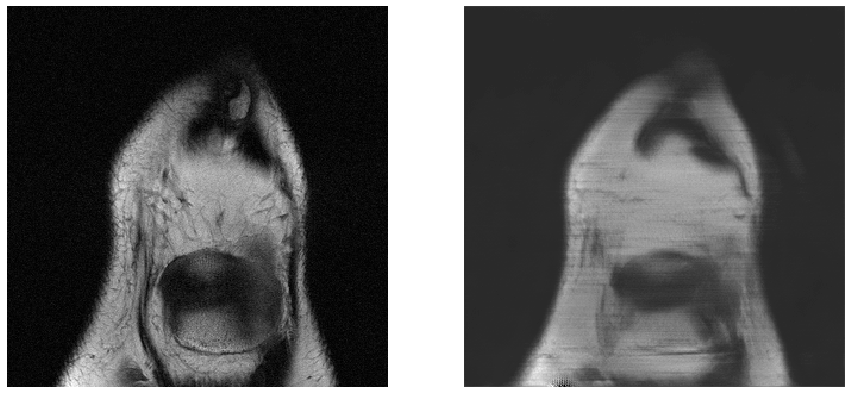

In [21]:
with torch.no_grad():
    for iteration, sample in enumerate(val_loader):
    
        img_gt, img_und = sample
    
        output_img = model(img_und.to(device).unsqueeze(1)).cpu().numpy().squeeze()
        show_slices([img_gt.squeeze(1).numpy()[6], output_img[6]], [0, 1], cmap='gray')
        
        if iteration >= 3: break

In [22]:
def save_reconstructions(reconstructions, out_dir, file_name):

    for fname, recons in reconstructions.items():
        subject_path = os.path.join(out_dir, file_name)
        with h5py.File(subject_path, 'a') as f:
            f.create_dataset(fname, data=recons)

In [24]:
test_path = '/data/local/NC2019MRI/test/'
files = []
file_names = []

for r, d, f in os.walk(test_path):
    for file in f:
        files.append(os.path.join(r, file))
        file_names.append(file)

with torch.no_grad():
    for i in range(len(files)):
        with h5py.File(files[i],  "r") as hf:
            volume_kspace_4af = hf['kspace_4af'][()]
            volume_kspace_8af = hf['kspace_8af'][()]
            volume_kspace4 = T.to_tensor(volume_kspace_4af)
            volume_kspace8 = T.to_tensor(volume_kspace_8af) 
            _4af, _8af = T.ifft2(volume_kspace4), T.ifft2(volume_kspace8)
            norm_4af = T.complex_abs(_4af).max()
            if norm_4af < 1e-6: norm_4af = 1e-6
            norm_8af = T.complex_abs(_8af).max()
            if norm_8af < 1e-6: norm_8af = 1e-6
            _4af = _4af / norm_4af
            _8af = _8af / norm_8af
            _4af = T.complex_abs(_4af.squeeze(0))
            _4af = T.center_crop(_4af, (320, 320)).to(device)
            _8af = T.complex_abs(_8af.squeeze(0))
            _8af = T.center_crop(_8af, (320, 320)).to(device)

            recon_4af = model(_4af.unsqueeze(1)).squeeze(1).cpu()
            recon_8af = model(_8af.unsqueeze(1)).squeeze(1).cpu()

            reconstructions = {'recon_4af': recon_4af.numpy(), 'recon_8af': recon_8af.numpy()}
            out_dir = 'saved/'
            if not (os.path.exists(out_dir)): os.makedirs(out_dir)
            save_reconstructions(reconstructions, out_dir, file_names[i])
        

RuntimeError: Can't decrement id ref count (unable to close file, errno = 122, error message = 'Disk quota exceeded')